<a href="https://colab.research.google.com/github/mehrnazeraeisi/Breast_Cancer/blob/main/Breast_Cancer_KnnClassification_Modification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_breast_cancer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [2]:
# [1] Prioritize features based on single-feature KNN accuracy
def prioritize_features_by_accuracy(X, y, features):
    feature_scores = []
    knn = KNeighborsClassifier()

    for feature in features:
        X_feature = X[[feature]]  # Ensure 2D shape
        knn.fit(X_feature, y)
        y_pred = knn.predict(X_feature)
        acc = accuracy_score(y, y_pred)
        feature_scores.append((feature, acc))

    df_scores = pd.DataFrame(feature_scores, columns=['Feature', 'Accuracy'])
    return df_scores.sort_values(by='Accuracy', ascending=False)

In [8]:
# [2] Safe accuracy computation for selected feature groups
def knn_accuracy(X, y, selected_features):
    if len(selected_features) == 0:
        return np.nan
    model = KNeighborsClassifier()
    X_subset = X[selected_features]
    model.fit(X_subset, y)
    y_pred = model.predict(X_subset)
    return accuracy_score(y, y_pred)


In [9]:

# [3] Load Breast_Cancer dataset
data = load_breast_cancer()
X_data = pd.DataFrame(data.data, columns=data.feature_names)
y_data = data.target
all_features = data.feature_names

In [10]:
# [4] Prioritize all features by single-feature accuracy
feature_scores = prioritize_features_by_accuracy(X_data, y_data, all_features)
print("🔎 Feature-wise Accuracy Ranking:")
print(feature_scores)


🔎 Feature-wise Accuracy Ranking:
                    Feature  Accuracy
23               worst area  0.929701
22          worst perimeter  0.926186
27     worst concave points  0.920914
20             worst radius  0.920914
2            mean perimeter  0.915641
7       mean concave points  0.915641
6            mean concavity  0.906854
3                 mean area  0.901582
0               mean radius  0.898067
13               area error  0.892794
26          worst concavity  0.869947
12          perimeter error  0.848858
10             radius error  0.840070
25        worst compactness  0.824253
5          mean compactness  0.817223
21            worst texture  0.780316
17     concave points error  0.780316
1              mean texture  0.769772
29  worst fractal dimension  0.768014
16          concavity error  0.766257
28           worst symmetry  0.764499
4           mean smoothness  0.764499
24         worst smoothness  0.760984
15        compactness error  0.760984
18           symm

In [11]:
# [5] Group features based on accuracy thresholds
strong_features = feature_scores[feature_scores['Accuracy'] > 0.95]['Feature'].tolist()
medium_features_1 = feature_scores[feature_scores['Accuracy'] > 0.9]['Feature'].tolist()
medium_features_2 = feature_scores[feature_scores['Accuracy'] > 0.8]['Feature'].tolist()
medium_features_3 = feature_scores[feature_scores['Accuracy'] > 0.7]['Feature'].tolist()
medium_features_4 = feature_scores[feature_scores['Accuracy'] > 0.6]['Feature'].tolist()
medium_features_5 = feature_scores[feature_scores['Accuracy'] > 0.5]['Feature'].tolist()
poor_features = feature_scores[feature_scores['Accuracy'] <= 0.5]['Feature'].tolist()

In [12]:
# [6] Evaluate grouped features using multi-feature KNN accuracy
groups = [all_features, strong_features, medium_features_1, medium_features_2,
          medium_features_3, medium_features_4, medium_features_5, poor_features]

acc_scores = [knn_accuracy(X_data, y_data, group) for group in groups]

# [7] Create summary table
summary_df = pd.DataFrame({
    'Feature Group': ['All Features', 'Strong Features', 'Medium (0.9-0.95)', 'Medium (0.8-0.9)',
                      'Medium (0.7-0.8)', 'Medium (0.6-0.7)', 'Medium (0.5-0.6)', 'Poor Features'],
    'Accuracy': acc_scores
})

print("\n📊 Grouped Feature Performance Summary:")
print(summary_df)


📊 Grouped Feature Performance Summary:
       Feature Group  Accuracy
0       All Features  0.947276
1    Strong Features       NaN
2  Medium (0.9-0.95)  0.942004
3   Medium (0.8-0.9)  0.945518
4   Medium (0.7-0.8)  0.947276
5   Medium (0.6-0.7)  0.947276
6   Medium (0.5-0.6)  0.947276
7      Poor Features       NaN


In [20]:
# [8] Final evaluation function: repeats KNN classification and plots accuracy over repeats
def evaluate_knn_accuracy_by_groups(X_data, y_data, medium_2, medium_3, all_features, test_size, n_repeats):
    accuracy_scores = {
        "all_features": [],
        "medium_features_2": [],
        "medium_features_3": []
    }

    feature_groups = {
        "all_features": all_features,
        "medium_features_2": medium_2,
        "medium_features_3": medium_3
    }

    for _ in range(n_repeats):
        X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=test_size)

        for group_name, group_features in feature_groups.items():
            k = int(np.sqrt(len(X_train)))
            knn = KNeighborsClassifier(n_neighbors=k)
            knn.fit(X_train[group_features], y_train)
            y_pred = knn.predict(X_test[group_features])
            acc = accuracy_score(y_test, y_pred)
            accuracy_scores[group_name].append(acc)

    # Plotting accuracy per repeat
    x = np.arange(1, n_repeats + 1)
    plt.figure(figsize=(8, 4))
    for group_name, acc_list in accuracy_scores.items():
        plt.plot(x, acc_list, label=f"{group_name.replace('_', ' ').title()}", marker='o')
    plt.xlabel('Repeat')
    plt.ylabel('Accuracy')
    plt.title('KNN Classifier Accuracy Over Repeats')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

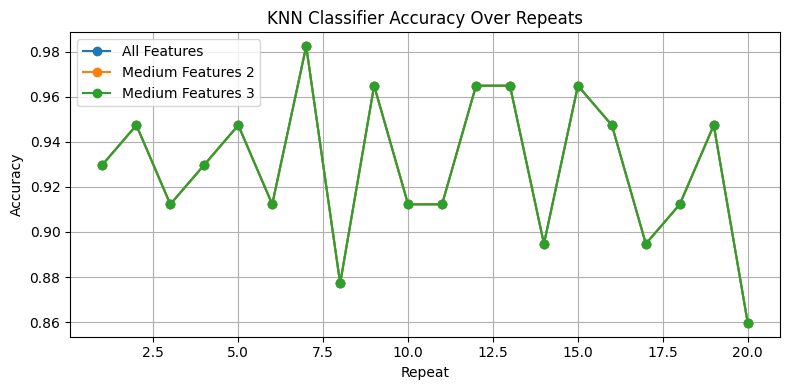

In [21]:
# [9] Run final evaluation
evaluate_knn_accuracy_by_groups(X_data, y_data, medium_features_2, medium_features_3, all_features, test_size=0.10, n_repeats=20)


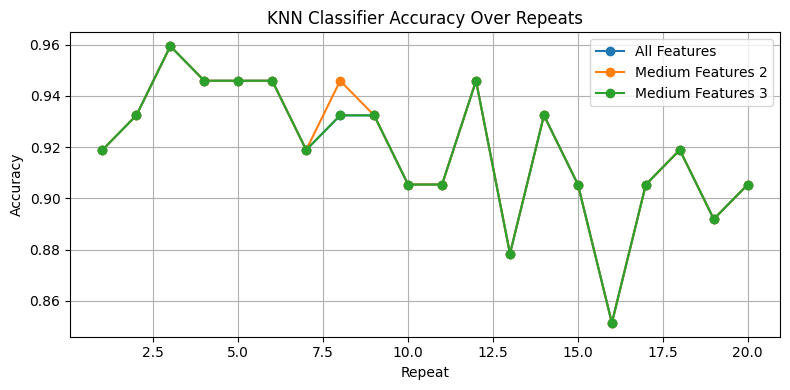

In [22]:
# [9] Run final evaluation
evaluate_knn_accuracy_by_groups(X_data, y_data, medium_features_2, medium_features_3, all_features, test_size=0.13, n_repeats=20)


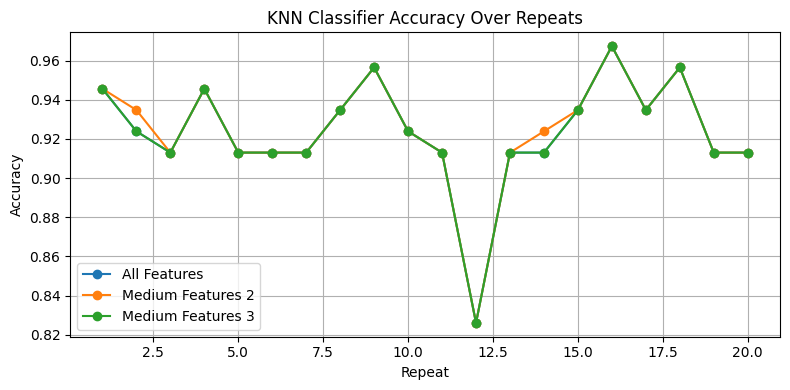

In [23]:
# [9] Run final evaluation
evaluate_knn_accuracy_by_groups(X_data, y_data, medium_features_2, medium_features_3, all_features, test_size=0.16, n_repeats=20)


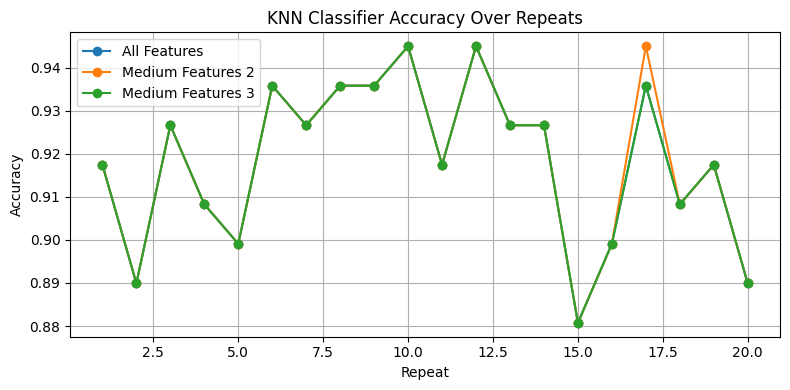

In [24]:
# [9] Run final evaluation
evaluate_knn_accuracy_by_groups(X_data, y_data, medium_features_2, medium_features_3, all_features, test_size=0.19, n_repeats=20)


🔎 Feature-wise Accuracy Ranking:
                    Feature  Accuracy
23               worst area  0.929701
22          worst perimeter  0.926186
27     worst concave points  0.920914
20             worst radius  0.920914
2            mean perimeter  0.915641
7       mean concave points  0.915641
6            mean concavity  0.906854
3                 mean area  0.901582
0               mean radius  0.898067
13               area error  0.892794
26          worst concavity  0.869947
12          perimeter error  0.848858
10             radius error  0.840070
25        worst compactness  0.824253
5          mean compactness  0.817223
21            worst texture  0.780316
17     concave points error  0.780316
1              mean texture  0.769772
29  worst fractal dimension  0.768014
16          concavity error  0.766257
28           worst symmetry  0.764499
4           mean smoothness  0.764499
24         worst smoothness  0.760984
15        compactness error  0.760984
18           symm

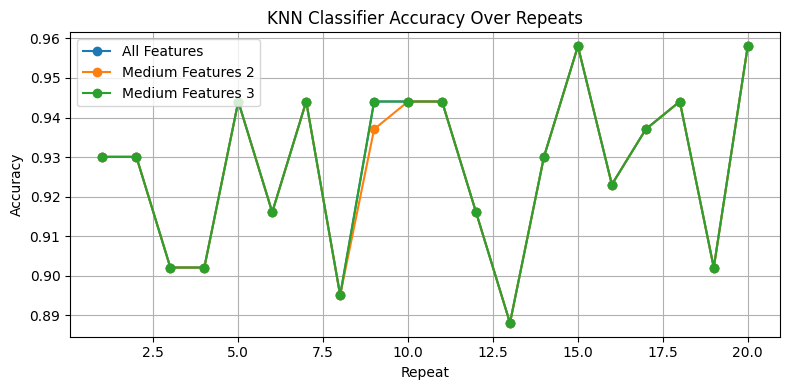

In [25]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_breast_cancer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# [1] Prioritize features based on single-feature KNN accuracy
def prioritize_features_by_accuracy(X, y, features):
    feature_scores = []
    knn = KNeighborsClassifier()

    for feature in features:
        X_feature = X[[feature]]  # Ensure 2D shape
        knn.fit(X_feature, y)
        y_pred = knn.predict(X_feature)
        acc = accuracy_score(y, y_pred)
        feature_scores.append((feature, acc))

    df_scores = pd.DataFrame(feature_scores, columns=['Feature', 'Accuracy'])
    return df_scores.sort_values(by='Accuracy', ascending=False)

# [2] Safe accuracy computation for selected feature groups
def knn_accuracy(X, y, selected_features):
    if len(selected_features) == 0:
        return np.nan
    model = KNeighborsClassifier()
    X_subset = X[selected_features]
    model.fit(X_subset, y)
    y_pred = model.predict(X_subset)
    return accuracy_score(y, y_pred)

# [3] Load breast_cancer dataset
data = load_breast_cancer()
X_data = pd.DataFrame(data.data, columns=data.feature_names)
y_data = data.target
all_features = data.feature_names

# [4] Prioritize all features by single-feature accuracy
feature_scores = prioritize_features_by_accuracy(X_data, y_data, all_features)
print("🔎 Feature-wise Accuracy Ranking:")
print(feature_scores)

# [5] Group features based on accuracy thresholds
strong_features = feature_scores[feature_scores['Accuracy'] > 0.95]['Feature'].tolist()
medium_features_1 = feature_scores[feature_scores['Accuracy'] > 0.9]['Feature'].tolist()
medium_features_2 = feature_scores[feature_scores['Accuracy'] > 0.8]['Feature'].tolist()
medium_features_3 = feature_scores[feature_scores['Accuracy'] > 0.7]['Feature'].tolist()
medium_features_4 = feature_scores[feature_scores['Accuracy'] > 0.6]['Feature'].tolist()
medium_features_5 = feature_scores[feature_scores['Accuracy'] > 0.5]['Feature'].tolist()
poor_features = feature_scores[feature_scores['Accuracy'] <= 0.5]['Feature'].tolist()

# [6] Evaluate grouped features using multi-feature KNN accuracy
groups = [all_features, strong_features, medium_features_1, medium_features_2,
          medium_features_3, medium_features_4, medium_features_5, poor_features]

acc_scores = [knn_accuracy(X_data, y_data, group) for group in groups]

# [7] Create summary table
summary_df = pd.DataFrame({
    'Feature Group': ['All Features', 'Strong Features', 'Medium (0.9-0.95)', 'Medium (0.8-0.9)',
                      'Medium (0.7-0.8)', 'Medium (0.6-0.7)', 'Medium (0.5-0.6)', 'Poor Features'],
    'Accuracy': acc_scores
})

print("\n📊 Grouped Feature Performance Summary:")
print(summary_df)

# [8] Final evaluation function: repeats KNN classification and plots accuracy over repeats
def evaluate_knn_accuracy_by_groups(X_data, y_data, medium_2, medium_3, all_features, test_size, n_repeats):
    accuracy_scores = {
        "all_features": [],
        "medium_features_2": [],
        "medium_features_3": []
    }

    feature_groups = {
        "all_features": all_features,
        "medium_features_2": medium_2,
        "medium_features_3": medium_3
    }

    for _ in range(n_repeats):
        X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=test_size)

        for group_name, group_features in feature_groups.items():
            k = int(np.sqrt(len(X_train)))
            knn = KNeighborsClassifier(n_neighbors=k)
            knn.fit(X_train[group_features], y_train)
            y_pred = knn.predict(X_test[group_features])
            acc = accuracy_score(y_test, y_pred)
            accuracy_scores[group_name].append(acc)

    # Plotting accuracy per repeat
    x = np.arange(1, n_repeats + 1)
    plt.figure(figsize=(8, 4))
    for group_name, acc_list in accuracy_scores.items():
        plt.plot(x, acc_list, label=f"{group_name.replace('_', ' ').title()}", marker='o')
    plt.xlabel('Repeat')
    plt.ylabel('Accuracy')
    plt.title('KNN Classifier Accuracy Over Repeats')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# [9] Run final evaluation
evaluate_knn_accuracy_by_groups(X_data, y_data, medium_features_2, medium_features_3, all_features, test_size=0.25, n_repeats=20)
